In [1]:
from utils import SurrogatPyRepEnvironment, SimulationEnvironment
from basic_walk.utils import BaseAgent
import sys
import time

from tqc import structures, DEVICE
from tqc.trainer import Trainer
from tqc.structures import Actor, Critic, RescaleAction
from tqc.functions import eval_policy
from tqdm import tqdm, trange
import copy
import torch

import pickle
import matplotlib.pyplot as plt
import numpy as np

# Base Agent

In [2]:
DEVICE

device(type='cuda')

In [4]:
headless_mode = True
foot_only_mode = True
random_mode = False
n_episodes = 2
episodes_length = 200
# tqc_model_file_name = f"data/models/model_{800000}_actor"
tqc_model_file_name = f"data/history/jumping_jack_actor"

base_agent_info_log = []
tqc_agent_info_log = []

In [5]:
%%time
with SimulationEnvironment('scenes/basic_scene.ttt', headless_mode=headless_mode, foot_only_mode=foot_only_mode) as env:
    for i in range(1):
        current_info = []
        agent = BaseAgent(random_mode=random_mode, foot_only_mode=foot_only_mode)
        
        state = env.reset()
        for _ in range(episodes_length):
            action = agent.act(state)
            state, r, done, info = env.step(action)
            current_info.append(info)
            
            if done:
                print("Fail")
                break
        
        base_agent_info_log.append(current_info)

CPU times: user 4.37 s, sys: 428 ms, total: 4.79 s
Wall time: 7.54 s


In [6]:
%%time
with SimulationEnvironment('scenes/basic_scene.ttt', headless_mode=headless_mode, foot_only_mode=foot_only_mode) as env:
    env = RescaleAction(env, -1., 1.)

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]

    agent = Actor(state_dim, action_dim).to(DEVICE)
    for i in range(n_episodes):
        agent.load_state_dict(torch.load(tqc_model_file_name))
        agent.eval()
        
        current_info = []
        state = env.reset()
        for _ in range(episodes_length):
            action = agent.select_action(state)
            state, r, done, info = env.step(action)
            current_info.append(info)
            
            if done:
                print("Fail")
                break
        
        tqc_agent_info_log.append(current_info)

Fail
CPU times: user 5.25 s, sys: 609 ms, total: 5.86 s
Wall time: 8.59 s


## Анализ

In [7]:
def extract_param(info_log, param_name):
    param = []
    for info in info_log:
        param.append(info[param_name])
    
    return param

def find_best_log(logs):
    max_reward = 0
    max_log = []
    for log in logs:
        curr_reward = np.sum(extract_param(log, "reward"))
        if curr_reward > max_reward:
            max_reward = curr_reward
            max_log = log
    return max_log

def plot_info_param(info_log, param_name, ax):
    param = extract_param(info_log, param_name)
    ax.plot(param, label=param_name)
    
def plot_two_info(first_info_log, second_info_log, param_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5))
    
    plot_info_param(first_info_log, param_name, ax=ax1)
    plot_info_param(second_info_log, param_name, ax=ax2)
    plt.legend()
    plt.show()

In [9]:
base_agent_best_log = find_best_log(base_agent_info_log)
tqc_agent_best_log = find_best_log(tqc_agent_info_log)
base_agent_best_log[0].keys()

dict_keys(['fall_metric', 'y', 'x', 'zpos', 'floor_collision', 'fall_prob', 'fall_reward', 'current_velocity', 'velocity_cross_prod', 'velocity_reward', 'mean_joint_distance', 'mean_joint_distance_normalized', 'smooth_reward', 'sum_forces', 'sum_forces_normalized', 'force_reward', 'self_collision', 'reward', 'action', 'state'])

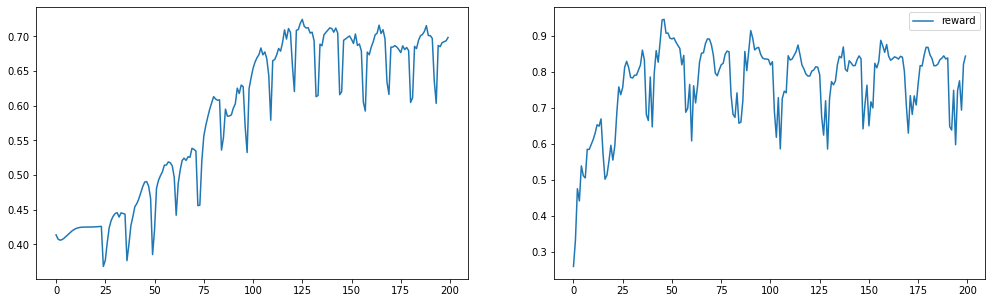

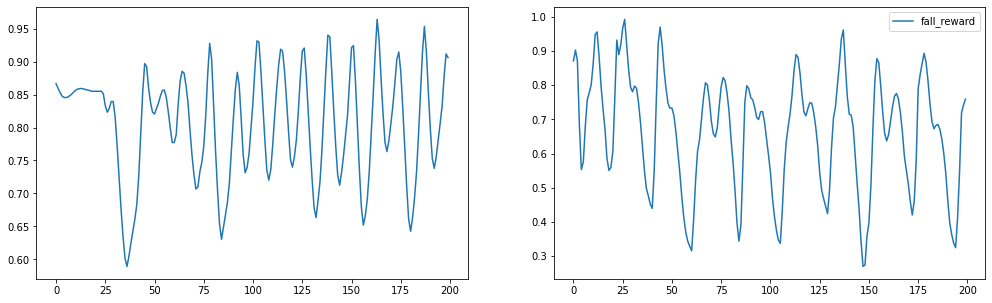

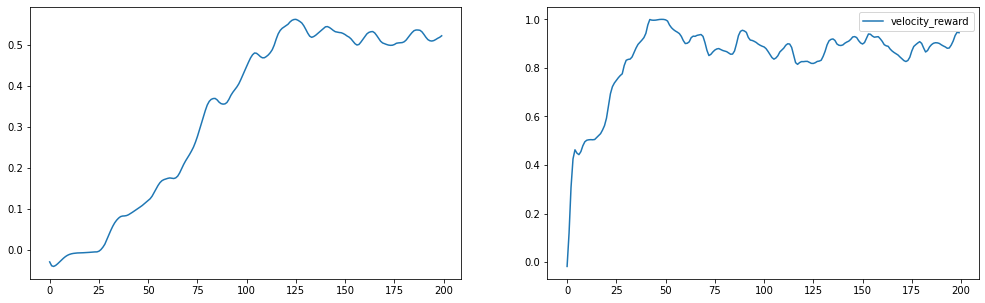

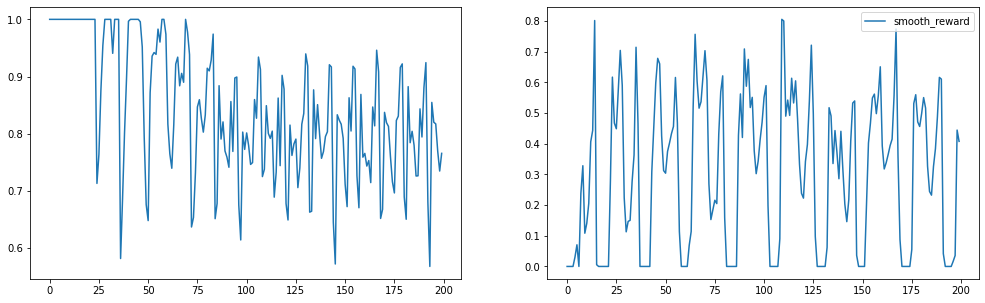

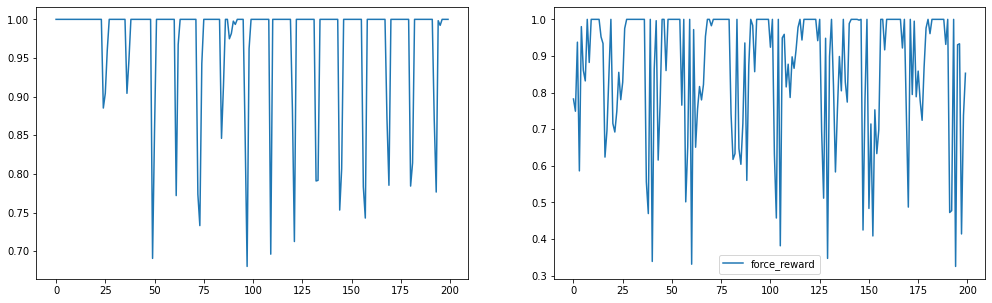

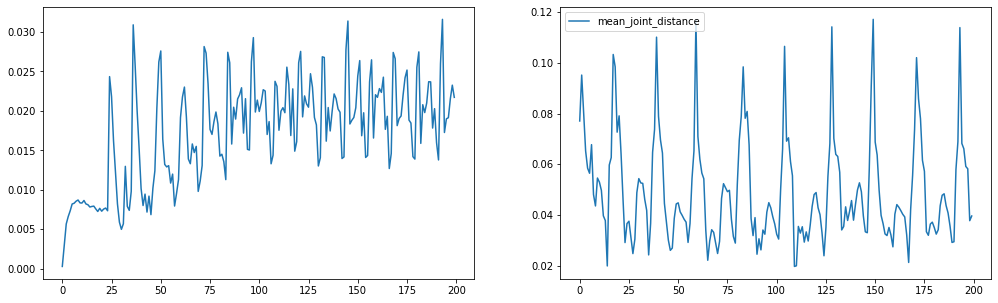

In [10]:
param_names = [
    "reward",
    "fall_reward",
    "velocity_reward",
    "smooth_reward",
    "force_reward",
    "mean_joint_distance"
]

for param_name in param_names:
    plot_two_info(base_agent_best_log, tqc_agent_best_log, param_name)